<img src="../../images/arm_logo.png" width=500 alt="ARM Logo"></img>

# Fun With Gatefilters

## Overview
   
Within this notebook, we will cover:

1. Introduce gatefilters
1. Show an example filtering on angle
1. Use this in a QVP

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Basic features |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic plotting |
| [NumPy Basics](https://foundations.projectpythia.org/core/numpy/numpy-basics.html) | Helpful | Basic arrays |

- **Time to learn**: 45 minutes
---

In [1]:
import os
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

import pyart
from pyart.testing import get_test_data
import xradar as xd
import numpy as np

warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Read in a C-SAPR file from the Bankhead National Forest. 
csapr = pyart.io.read('bnfcsapr2cfrS3.a1.20250422.040012.nc')

In [28]:
csapr.metadata['doi']

'10.5439/1467901'

https://www.osti.gov/dataexplorer/biblio/dataset/1467901-band-scanning-arm-precipitation-radar-generation

Bharadwaj, Nitin, Collis, Scott, Hardin, Joseph, Isom, Bradley, Lindenmaier, Iosif, Matthews, Alyssa, Nelson, Danny, Feng, Ya-Chien, Rocque, Marquette, Wendler, Tim, and Castro, Vagner. C-Band Scanning ARM Precipitation Radar, 2nd Generation. United States: N. p., 2021. Web. doi:10.5439/1467901.

In [3]:
# Simply my favourite colormap
my_favorite_colormap = pyart.graph.cmweather.cm_colorblind.ChaseSpectral

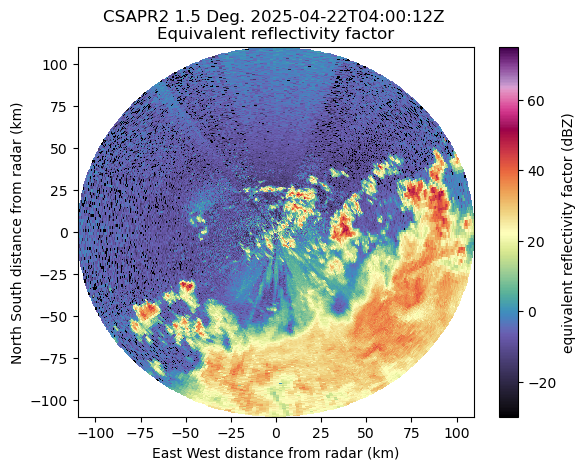

In [17]:
mydc = pyart.graph.RadarDisplay(csapr)
mydc.plot_ppi('reflectivity', cmap=my_favorite_colormap)

In [18]:
mygf = gatefilter = pyart.correct.GateFilter(csapr)
mygf.exclude_below('reflectivity', 0) 


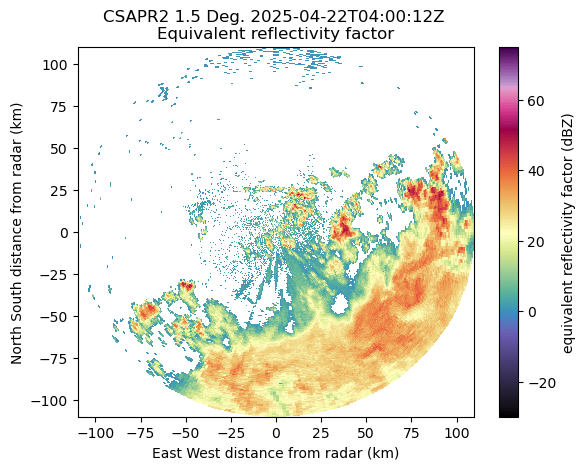

In [19]:
mydc = pyart.graph.RadarDisplay(csapr)
mydc.plot_ppi('reflectivity', cmap=my_favorite_colormap, gatefilter=mygf)

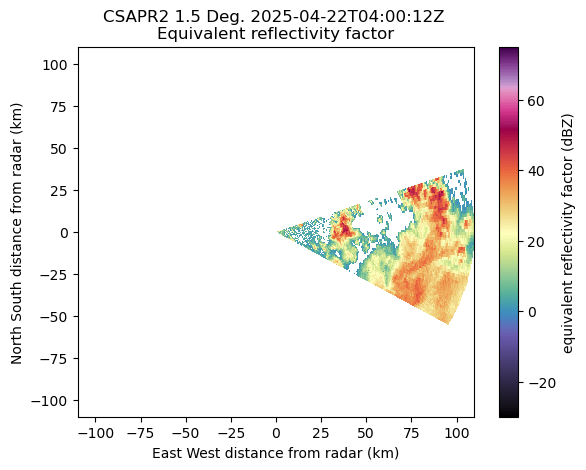

In [20]:
#Get Azimuths
azmth = csapr.azimuth['data']

#Make this into the same shape as our radar field data
azmth_square = np.repeat(np.expand_dims(azmth, 1), len(csapr.range['data']), axis=1)

#add the field
csapr.add_field_like('reflectivity', 'azsq', azmth_square, replace_existing=True)

#Make a gate filter
mygf_angles = pyart.correct.GateFilter(csapr)

#filter on aziumth, 10 to 20 degrees
mygf_angles.exclude_outside('azsq', 70,120) 
mygf_angles.exclude_invalid('reflectivity') 
mygf_angles.exclude_below('reflectivity', 0) 

#See what we got
myd = pyart.graph.RadarDisplay(csapr)
myd.plot_ppi('reflectivity', gatefilter = mygf_angles, cmap=my_favorite_colormap)



In [21]:
myvp_ang = pyart.retrieve.quasi_vertical_profile(csapr, fields='reflectivity', desired_angle =5, gatefilter=mygf_angles)
myvp_full = pyart.retrieve.quasi_vertical_profile(csapr, fields='reflectivity', desired_angle =5, gatefilter=mygf)


[ 1.4996338  2.4993896  3.4991455  4.4989014  5.498657   6.498413
  7.998047   9.997559  12.002563  14.002075  17.50122   21.500244
 25.999146  32.997437  42.000732 ]
41.97876
[ 1.4996338  2.4993896  3.4991455  4.4989014  5.498657   6.498413
  7.998047   9.997559  12.002563  14.002075  17.50122   21.500244
 25.999146  32.997437  42.000732 ]
41.97876


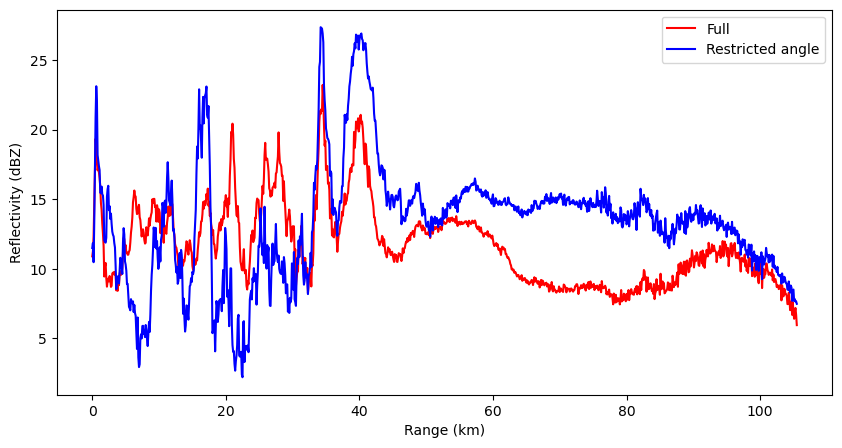

In [31]:
myf = plt.figure(figsize=[10,5])
plt.plot(csapr.range['data']/1000.0, myvp_full['reflectivity'], color='r', label='Full')
plt.plot(csapr.range['data']/1000.0, myvp_ang['reflectivity'], color='b', label='Restricted angle')
plt.xlabel('Range (km)')
plt.ylabel('Reflectivity (dBZ)')
plt.legend()
